In [1]:
import torch
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from glob import glob
import warnings
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
path_to_images = 'Dataset/allImages/'

In [3]:
df = pd.read_csv('Dataset/all_images.csv')

In [4]:
df.head()

,Unnamed: 0,image_id,category
0,0,52fb49e00e.jpg,engineBlock
1,1,a4e7b0ad35.jpg,engineBlock
2,2,0a06a44398.jpg,engineBlock
3,3,bd67e4da46.jpg,engineBlock
4,4,36543856d8.jpg,engineBlock


In [5]:
# X_train,X_val,_,_ = train_test_split(df,df['category'],stratify=df['category'],test_size = 0.1)

In [6]:
# X_train['type'] = "train"

In [7]:
# X_val['type'] = "val"

In [8]:
# X_train.to_csv('train.csv')

In [9]:
# X_val.to_csv('val.csv')

In [10]:
X_train = pd.read_csv("train.csv")
X_val = pd.read_csv("val.csv")

In [11]:
df = pd.concat([X_train,X_val])

In [12]:
len(df)

1236

In [13]:
df.type.value_counts()

train    1112
val       124
Name: type, dtype: int64

# Model

In [14]:
import torch
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from glob import glob
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader,sampler,Dataset
from torchvision import models
import torch.nn as nn
from torch import Tensor
from torch.nn import functional as F
from torch import optim
import tqdm
from PIL import Image
import matplotlib.pyplot as plt

In [15]:
image_path = 'Dataset/allImages/'

In [16]:
save_file_name = "resnet50-transfer.pt"
checkpoint_path = "resnet50-transfer.pth"

In [17]:
image_transforms = {
    'train':transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    'valid':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [18]:
example_image = Image.open(image_path+df.iloc[1]['image_id'])

In [19]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

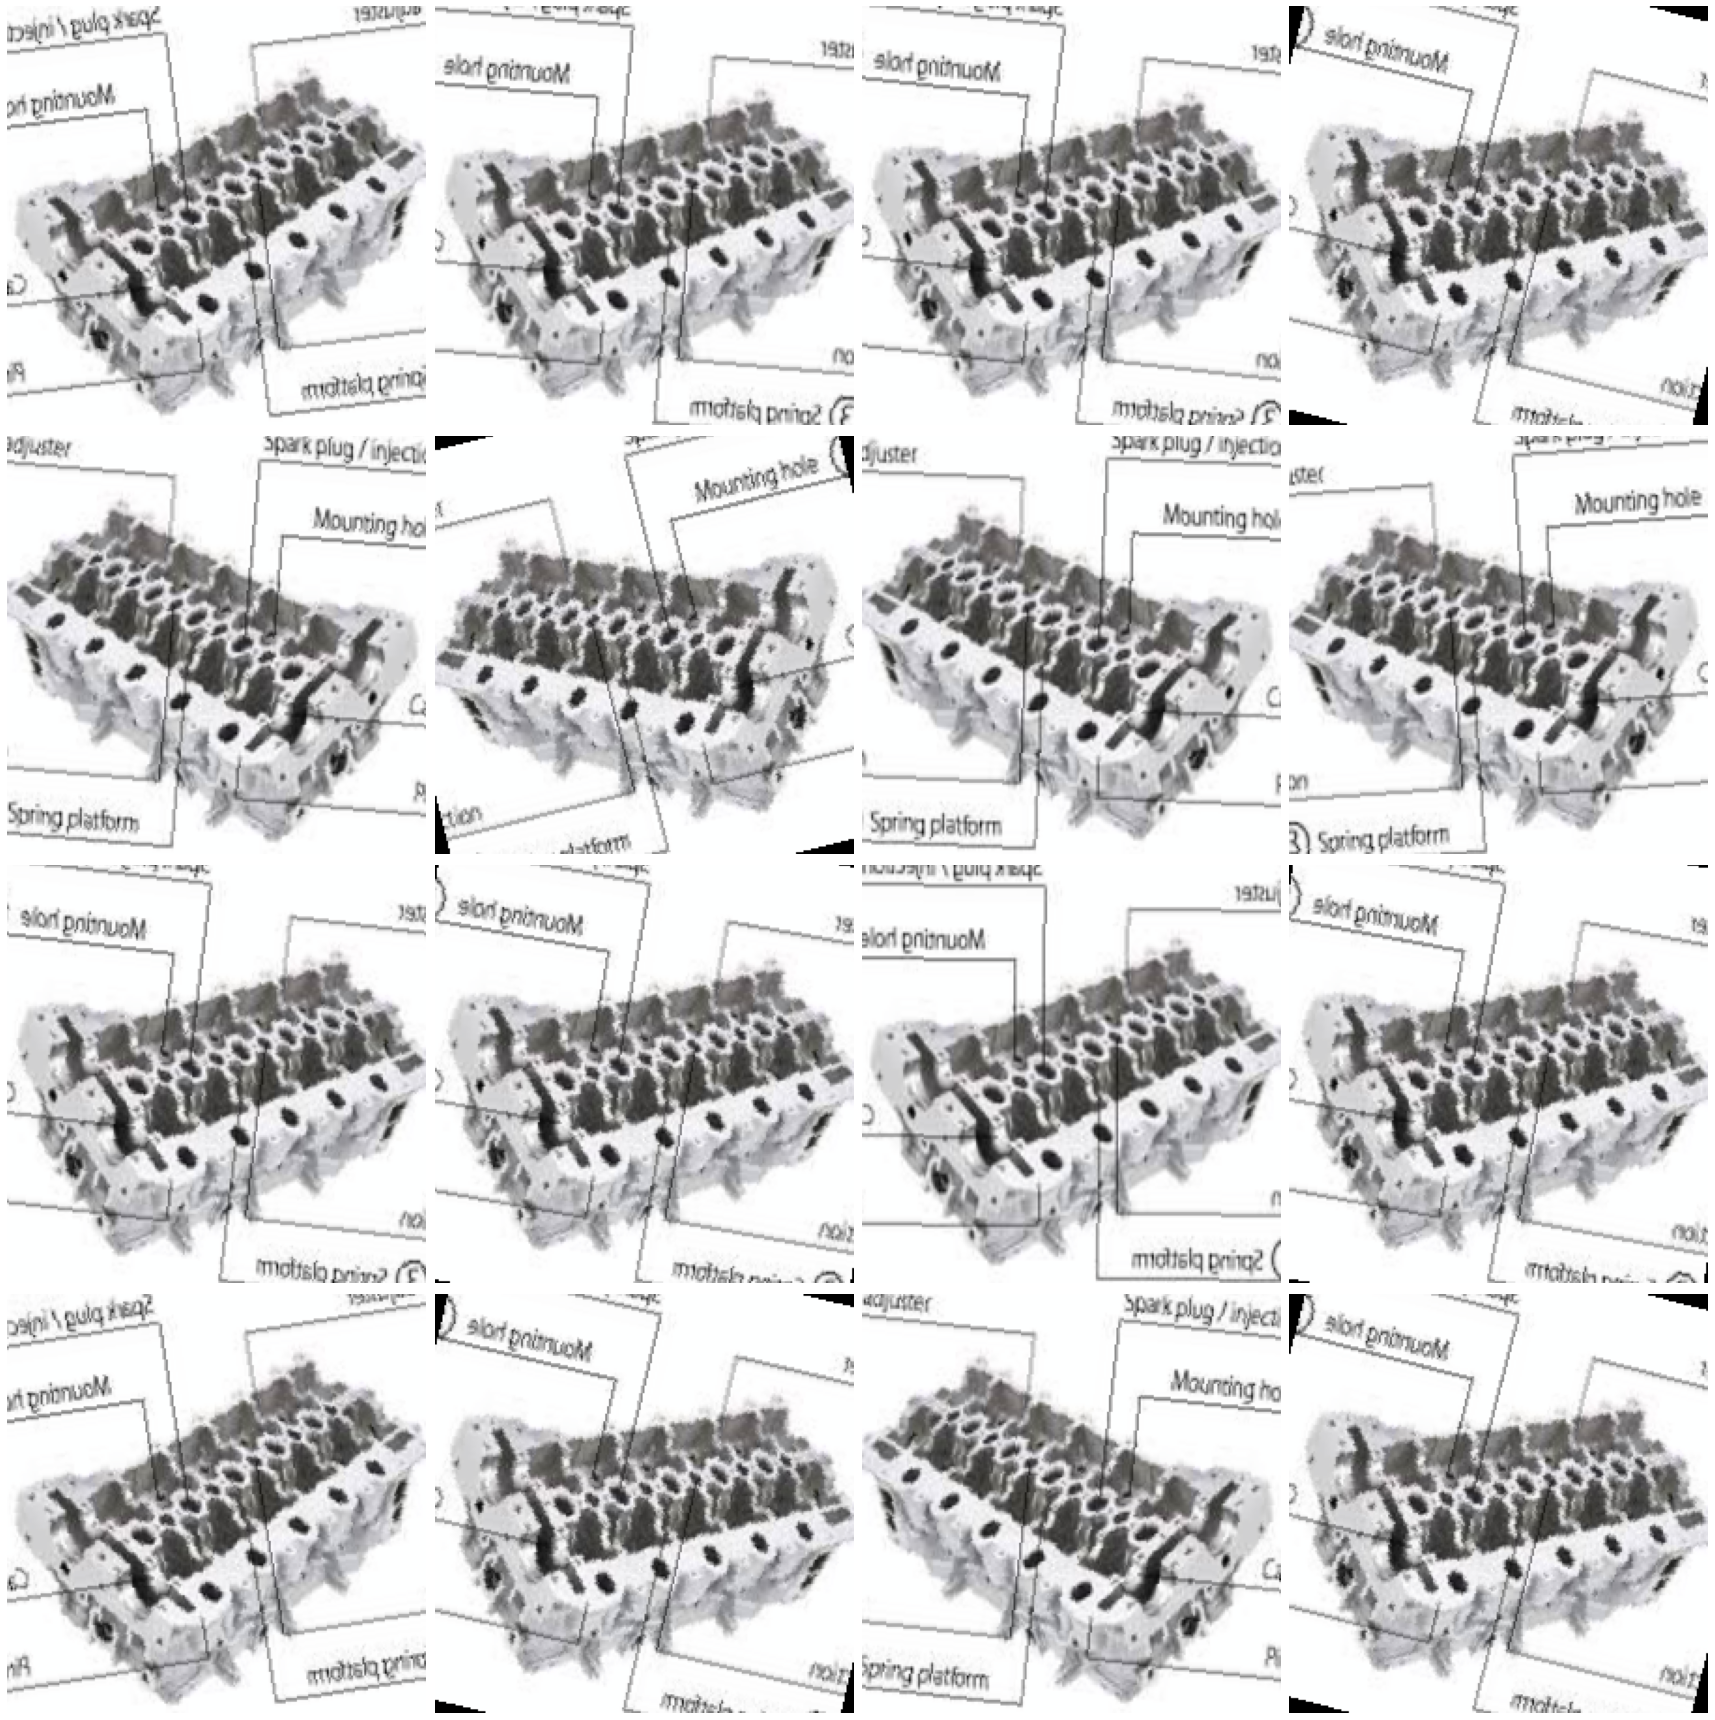

In [20]:
t = image_transforms['train']
plt.figure(figsize=(24,24))

for i in range(16):
    ax = plt.subplot(4,4,i+1)
    _ = imshow_tensor(t(example_image),ax=ax)
plt.tight_layout()

# Dataloader

In [22]:
X_train['category'].value_counts()

engineBlock      341
cylinderHeads    264
timingBelt       216
crankShaft       170
piston           121
Name: category, dtype: int64

In [77]:
indexing = {
    'engineBlock':0,
    'cylinderHeads':1,
    'timingBelt':2,
    'crankShaft':3,
    'piston':4    
}
predictions_index = {
    0:'Engine Block',
    1:'Cylinder Head',
    2:'Timing Belt',
    3:'Crank Shaft',
    4:'Piston'
}

In [24]:
class engineDataset(Dataset):
    def __init__(self,df,root_dir,transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        image_path = self.root_dir +self.df.iloc[idx]['image_id']
        image = Image.open(image_path)
        class_part = self.df.iloc[idx]['category']
        if self.transform:
            image = self.transform['train'](image)
        return image,indexing[class_part]

In [25]:
engine_train_dataset = engineDataset(df=X_train,root_dir=image_path,transform=image_transforms)
engine_val_dataset = engineDataset(df=X_val,root_dir=image_path,transform=image_transforms)
train_dl = DataLoader(engine_train_dataset,batch_size=32,shuffle=True)
val_dl = DataLoader(engine_val_dataset,batch_size=32,shuffle=False)

In [26]:
for i in range(len(engine_train_dataset)):
    img,class_part = engine_train_dataset[i]
    print(img.shape)
    print(class_part)
    break

torch.Size([3, 224, 224])
2


In [27]:
for x,y in train_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [28]:
trainiter = iter(train_dl)
features,labels = next(trainiter)
features.shape,labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

# Models

In [29]:
model = models.resnet50(pretrained=True)

In [30]:
for param in model.parameters():
    param.requires_grad = False

In [31]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [32]:
n_inputs = model.fc.in_features
num_classes = 5

In [33]:
model.fc = nn.Sequential(
    nn.Linear(n_inputs,256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256,num_classes),
    nn.LogSoftmax(dim=1)
)

In [34]:
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=256, out_features=5, bias=True)
  (4): LogSoftmax(dim=1)
)

In [40]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())
train_on_gpu = False

In [43]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

#     overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
#         start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete.')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
#                         total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
#     total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [48]:
model, history = train(
    model,
    criterion,
    optimizer,
    train_dl,
    val_dl,
    save_file_name=save_file_name,
    max_epochs_stop=3,
    n_epochs=5,
    print_every=1)

Model has been trained for: 2 epochs.

Epoch: 0	2.86% complete.
Epoch: 0	5.71% complete.
Epoch: 0	8.57% complete.
Epoch: 0	11.43% complete.
Epoch: 0	14.29% complete.
Epoch: 0	17.14% complete.
Epoch: 0	20.00% complete.
Epoch: 0	22.86% complete.
Epoch: 0	25.71% complete.
Epoch: 0	28.57% complete.
Epoch: 0	31.43% complete.
Epoch: 0	34.29% complete.
Epoch: 0	37.14% complete.
Epoch: 0	40.00% complete.
Epoch: 0	42.86% complete.
Epoch: 0	45.71% complete.
Epoch: 0	48.57% complete.
Epoch: 0	51.43% complete.
Epoch: 0	54.29% complete.
Epoch: 0	57.14% complete.
Epoch: 0	60.00% complete.
Epoch: 0	62.86% complete.
Epoch: 0	65.71% complete.
Epoch: 0	68.57% complete.
Epoch: 0	71.43% complete.
Epoch: 0	74.29% complete.
Epoch: 0	77.14% complete.
Epoch: 0	80.00% complete.
Epoch: 0	82.86% complete.
Epoch: 0	85.71% complete.
Epoch: 0	88.57% complete.
Epoch: 0	91.43% complete.
Epoch: 0	94.29% complete.
Epoch: 0	97.14% complete.
Epoch: 0	100.00% complete.

Epoch: 0 	Training Loss: 0.6027 	Validation Loss: 0.

Text(0.5, 1.0, 'Training and Validation Losses')

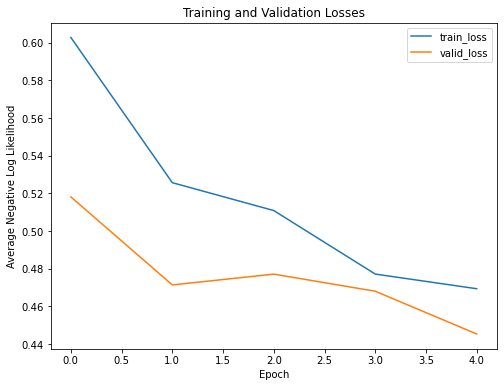

In [49]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

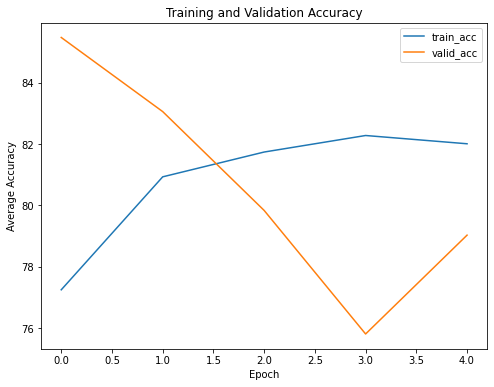

In [50]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [56]:
def save_checkpoint(model, path):
    """Save a PyTorch model checkpoint

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """
    multi_gpu = False
    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Basic details
    checkpoint = {
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    if model_name == 'vgg16':
        # Check to see if model was parallelized
        if multi_gpu:
            checkpoint['classifier'] = model.module.classifier
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['classifier'] = model.classifier
            checkpoint['state_dict'] = model.state_dict()

    elif model_name == 'resnet50':
        if multi_gpu:
            checkpoint['fc'] = model.module.fc
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['fc'] = model.fc
            checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)

In [57]:
save_checkpoint(model, path=checkpoint_path)

In [62]:
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """
    multi_gpu = False
    # Get the model name
    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Load in checkpoint
    checkpoint = torch.load(path)

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.fc = checkpoint['fc']

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')

    # Move to gpu
    if multi_gpu:
        model = nn.DataParallel(model)

    if train_on_gpu:
        model = model.to('cuda')

    # Model basics
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [63]:
model, optimizer = load_checkpoint(path=checkpoint_path)

24,033,861 total parameters.
525,829 total gradient parameters.


# Inferrence

In [64]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [74]:
def predict(image_path, model, topk=5):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns
        
    """
    real_class = image_path.split('/')[-2]

    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        
        return topclass[0][0]

In [86]:
image_p = 'Dataset/allImages/038134614a.jpg' 

In [87]:
im = Image.open(image_p)

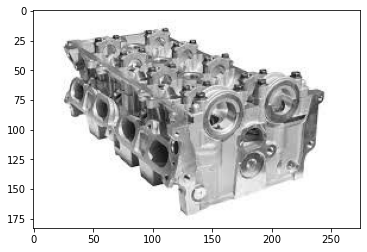

In [88]:
plt.imshow(im)

In [89]:
predictions_index[int(predict(image_p,model))]

'Engine Block'